https://medium.com/@norman-lm-fung/how-much-can-btc-move-per-hour-per-day-b2fb43953fdc

# Imports

In [33]:
import os
import sys
import tzlocal
from datetime import datetime, timezone
import time
import logging
from typing import Dict, List, Tuple, Union, NoReturn
import math
import pandas as pd
import numpy as np
from scipy.stats import linregress
import statsmodels.api as sm # in-compatible with pypy
from hurst import compute_Hc # compatible with pypy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, MaxNLocator
import random

from ccxt.bitmex import bitmex
from ccxt.base.exchange import Exchange
from ccxt.base.exchange import Exchange as CcxtExchange

# https://www.analyticsvidhya.com/blog/2021/06/download-financial-dataset-using-yahoo-finance-in-python-a-complete-guide/
from yahoofinancials import YahooFinancials

# yfinance allows intervals '1m', '5m', '15m', '1h', '1d', '1wk', '1mo'. yahoofinancials not as flexible
import yfinance as yf

from util.market_data_util import fetch_candles, compute_candles_stats

REPORT_NAME : str = "btc_candle_sizes"
CACHE_CANDLES : str = f"{os.path.dirname(sys.path[0])}\\casin0_bt\\cache\\research\\candles"

# Parameters (Higher Timeframe)

In [ ]:
num_candles_limit : int = 100 # Depends on exchange but generally 100 ok!
param = {
        'apiKey' : None,
        'secret' : None,
        'password' : None,    # Other exchanges dont require this! This is saved in exchange.password!
        'subaccount' : None,
        'rateLimit' : 100,    # In ms
        'options' : {
            'defaultType': 'swap', # Should test linear instead
            'leg_room_bps' : 5,
            'trade_fee_bps' : 3
        }
    }

ticker : str = 'BTC/USDT:USDT'
dt_start : datetime = datetime(2020,1,1)
dt_end : datetime = datetime(2024,11,17)
ts_candle_size : str = '1d'

force_reload : bool = True

sliding_window_how_many_candles_rsi : int = 14 # 14 is standard for RSI. If you want see spikes >70 and <30, use this config.
sliding_window_how_many_candles_ema : int = 90

# atm, only support one single exchange
target_exchange =  bitmex(param)
target_exchange.name='bitmex_linear'

full_report_name : str = f"{REPORT_NAME}_"

logging.Formatter.converter = time.gmtime
logger = logging.getLogger(REPORT_NAME)
log_level = logging.INFO # DEBUG --> INFO --> WARNING --> ERROR
logger.setLevel(log_level)
format_str = '%(asctime)s %(message)s'
formatter = logging.Formatter(format_str)

sh = logging.StreamHandler()
sh.setLevel(log_level)
sh.setFormatter(formatter)
logger.addHandler(sh)
fh = logging.FileHandler(f"{full_report_name}.log")
fh.setLevel(log_level)
fh.setFormatter(formatter)
logger.addHandler(fh)

# Fetch Candles

In [88]:
_ticker = ticker.split(":")[0].replace("/","")
target_candle_file_name : str = f'{_ticker}_candles_{dt_start.strftime("%Y-%m-%d-%H-%M-%S")}_{dt_end.strftime("%Y-%m-%d-%H-%M-%S")}_{ts_candle_size}.csv'
if force_reload or not os.path.isfile(target_candle_file_name):
    daily_candles = fetch_candles(
                                start_ts=dt_start.timestamp(),
                                end_ts=dt_end.timestamp(),
                                exchange=target_exchange,
                                normalized_symbols=[ticker],
                                candle_size = ts_candle_size,
                                how_many_candles = sliding_window_how_many_candles,
                                num_candles_limit=num_candles_limit,
                                logger=logger,
                                cache_dir=CACHE_CANDLES
                                )
    daily_candles = daily_candles[ticker]
    daily_candles.to_csv(target_candle_file_name)
else:
    daily_candles = pd.read_csv(target_candle_file_name)
    fix_column_types(daily_candles)

daily_candles.loc[:,'close_delta'] = daily_candles['close'].diff()
daily_candles.loc[:,'close_delta_percent'] = daily_candles['close'].pct_change()

daily_candles_rsi = daily_candles
daily_candles_ema = daily_candles.copy(deep=True)

compute_candles_stats(
      pd_candles=daily_candles_rsi,
      boillenger_std_multiples=2,
      sliding_window_how_many_candles=sliding_window_how_many_candles_rsi,
      slow_fast_interval_ratio=3
    )

compute_candles_stats(
      pd_candles=daily_candles_ema,
      boillenger_std_multiples=2,
      sliding_window_how_many_candles=sliding_window_how_many_candles_ema,
      slow_fast_interval_ratio=3
    )

hi_daily_candles = daily_candles_ema

d:\dev\siglab\siglab_py\util\market_data_util.py:357: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_slope = pd_candles['close'].rolling(window=int(sliding_window_how_many_candles/slow_fast_interval_ratio)).apply(lambda x: sm.OLS(x, X[:len(x)]).fit().params[1], raw=False)
d:\dev\siglab\siglab_py\util\market_data_util.py:361: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_slope = pd_candles['close'].rolling(window=sliding_window_how_many_candles).apply(lambda x: sm.OLS(x, X[:len(x)]).fit().params[1], raw=False)
d:\dev\siglab\siglab_py\util\market_data_util.py:365: FutureWarning: Series.__getitem__ treati

# Visualize

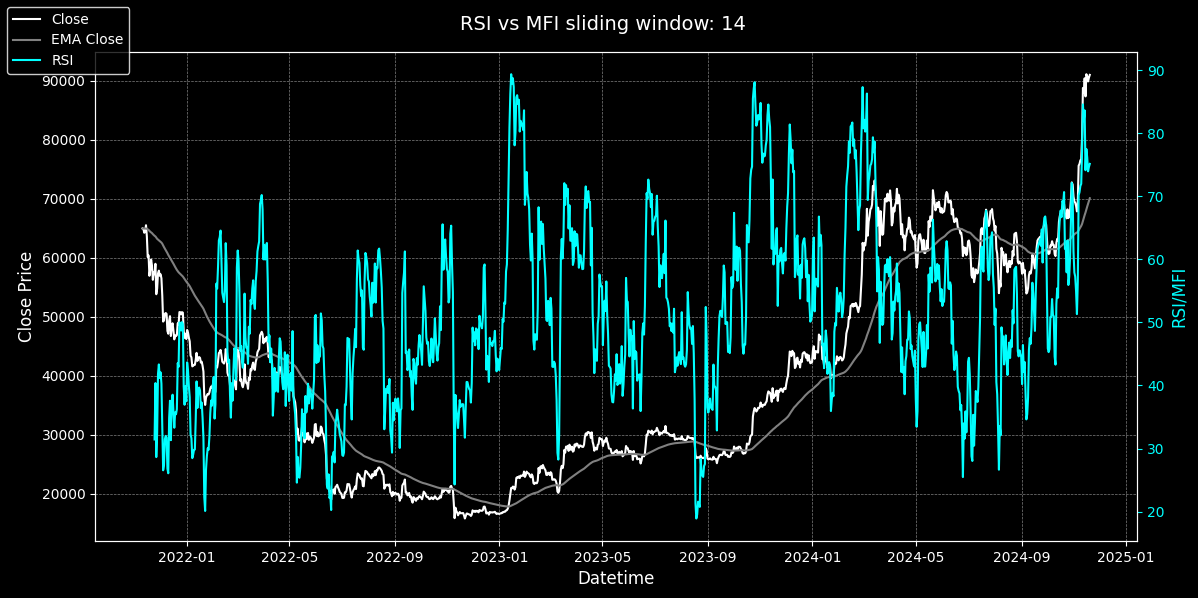

In [89]:
plt.style.use('dark_background')

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(daily_candles_ema['datetime'], daily_candles_ema['close'], color='white', label='Close')
ax1.plot(daily_candles_ema['datetime'], daily_candles_ema['ema_close'], color='gray', label='EMA Close')
ax1.set_xlabel('Datetime', fontsize=12, color='white')
ax1.set_ylabel('Close Price', fontsize=12, color='white')
ax1.tick_params(axis='y', colors='white')
ax1.tick_params(axis='x', colors='white')
ax1.grid(color='gray', linestyle='--', linewidth=0.5)

ax2 = ax1.twinx()
ax2.plot(daily_candles_rsi['datetime'], daily_candles_rsi['rsi'], color='cyan', label='RSI')
# ax2.plot(daily_candles_rsi['datetime'], daily_candles_rsi['mfi'], color='blue', label='MFI')
ax2.set_ylabel('RSI/MFI', fontsize=12, color='cyan')
ax2.tick_params(axis='y', colors='cyan')

fig.suptitle(f'RSI vs MFI sliding window: {sliding_window_how_many_candles}', fontsize=14, color='white')

fig.legend(loc='upper left', fontsize=10, facecolor='black', edgecolor='white')

plt.tight_layout()
plt.show()


# Parameters (Lower Timeframe)

In [ ]:
dt_start : datetime = datetime(2024,10,1)
dt_end : datetime = datetime(2024,10,30)
ts_candle_size : str = '1h'

force_reload : bool = True

sliding_window_how_many_candles_rsi : int = 14 # For RSI, 14 is standard.  If you want see spikes >70 and <30, use this config.

# Fetch Candles

In [92]:
_ticker = ticker.split(":")[0].replace("/","")
target_candle_file_name : str = f'{_ticker}_candles_{dt_start.strftime("%Y-%m-%d-%H-%M-%S")}_{dt_end.strftime("%Y-%m-%d-%H-%M-%S")}_{ts_candle_size}.csv'
if force_reload or not os.path.isfile(target_candle_file_name):
    daily_candles = fetch_candles(
                                start_ts=dt_start.timestamp(),
                                end_ts=dt_end.timestamp(),
                                exchange=target_exchange,
                                normalized_symbols=[ticker],
                                candle_size = ts_candle_size,
                                how_many_candles = sliding_window_how_many_candles,
                                num_candles_limit=num_candles_limit,
                                logger=logger,
                                cache_dir=CACHE_CANDLES
                                )
    daily_candles = daily_candles[ticker]
    daily_candles.to_csv(target_candle_file_name)
else:
    daily_candles = pd.read_csv(target_candle_file_name)
    fix_column_types(daily_candles)

daily_candles.loc[:,'close_delta'] = daily_candles['close'].diff()
daily_candles.loc[:,'close_delta_percent'] = daily_candles['close'].pct_change()

daily_candles_rsi = daily_candles
daily_candles_ema = daily_candles.copy(deep=True)

compute_candles_stats(
      pd_candles=daily_candles_rsi,
      boillenger_std_multiples=2,
      sliding_window_how_many_candles=sliding_window_how_many_candles_rsi,
      slow_fast_interval_ratio=3
    )

lo_daily_candles = daily_candles

d:\dev\siglab\siglab_py\util\market_data_util.py:357: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_slope = pd_candles['close'].rolling(window=int(sliding_window_how_many_candles/slow_fast_interval_ratio)).apply(lambda x: sm.OLS(x, X[:len(x)]).fit().params[1], raw=False)
d:\dev\siglab\siglab_py\util\market_data_util.py:361: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_slope = pd_candles['close'].rolling(window=sliding_window_how_many_candles).apply(lambda x: sm.OLS(x, X[:len(x)]).fit().params[1], raw=False)
d:\dev\siglab\siglab_py\util\market_data_util.py:365: FutureWarning: Series.__getitem__ treati

# Visualize

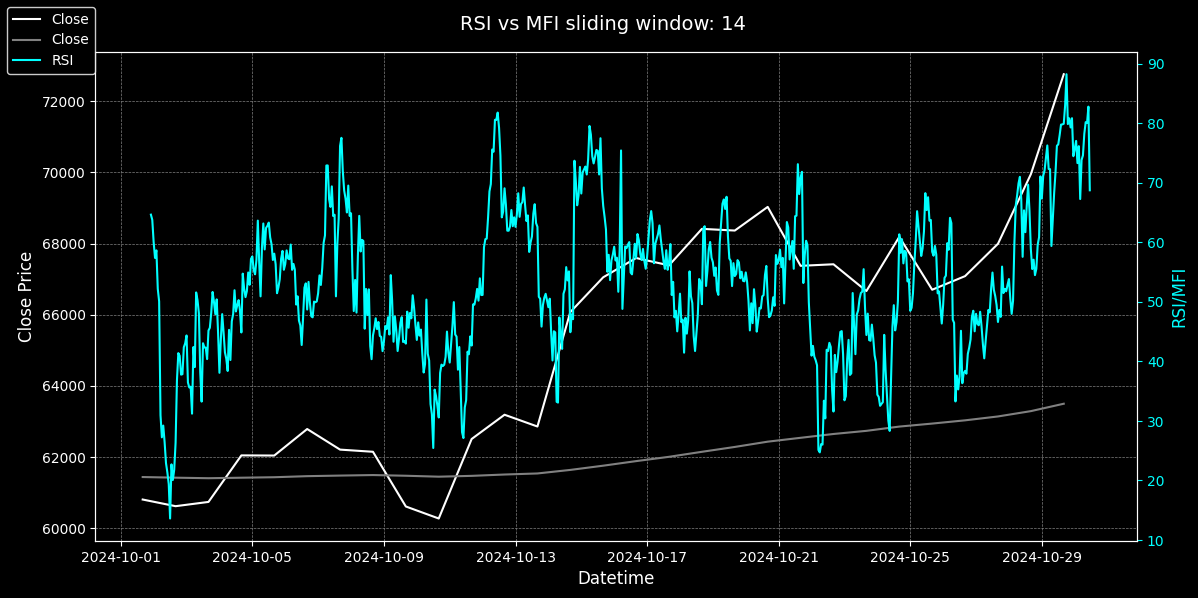

In [93]:
plt.style.use('dark_background')

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(hi_daily_candles[(hi_daily_candles['datetime']>dt_start) & (hi_daily_candles['datetime']<dt_end)]['datetime'], hi_daily_candles[(hi_daily_candles['datetime']>dt_start) & (hi_daily_candles['datetime']<dt_end)]['close'], color='white', label='Close')
ax1.plot(hi_daily_candles[(hi_daily_candles['datetime']>dt_start) & (hi_daily_candles['datetime']<dt_end)]['datetime'], hi_daily_candles[(hi_daily_candles['datetime']>dt_start) & (hi_daily_candles['datetime']<dt_end)]['ema_close'], color='gray', label='Close')
ax1.set_xlabel('Datetime', fontsize=12, color='white')
ax1.set_ylabel('Close Price', fontsize=12, color='white')
ax1.tick_params(axis='y', colors='white')
ax1.tick_params(axis='x', colors='white')
ax1.grid(color='gray', linestyle='--', linewidth=0.5)

ax2 = ax1.twinx()
ax2.plot(lo_daily_candles['datetime'], lo_daily_candles['rsi'], color='cyan', label='RSI')
# ax2.plot(lo_daily_candles['datetime'], lo_daily_candles['mfi'], color='blue', label='MFI')
ax2.set_ylabel('RSI/MFI', fontsize=12, color='cyan')
ax2.tick_params(axis='y', colors='cyan')

fig.suptitle(f'RSI vs MFI sliding window: {sliding_window_how_many_candles}', fontsize=14, color='white')

fig.legend(loc='upper left', fontsize=10, facecolor='black', edgecolor='white')

plt.tight_layout()
plt.show()
